# 0. loading the audio files & samples visualization 

In [1]:
import os  # Importing the 'os' module to interact with the file system

# Path to your dataset folder
dataset_path = "./free-spoken-digit-dataset-master/recordings/"  # Specify the folder where your dataset is located

# List all files in the specified directory
data_list = os.listdir(dataset_path)  # Retrieves all files and directories in the dataset folder
count = 0
# Loop to print all the files in the directory
for i in range(len(data_list)):  # Loop through all files in the directory
    #print(data_list[i])
    count += 1# Print each file's name in the dataset list
print(count)

3000


In [3]:
# print(data_list)

# 1. Time-domain Analysis 

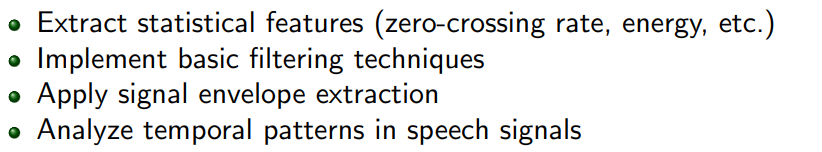

C:\Users\pc\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\pc\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\pc\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


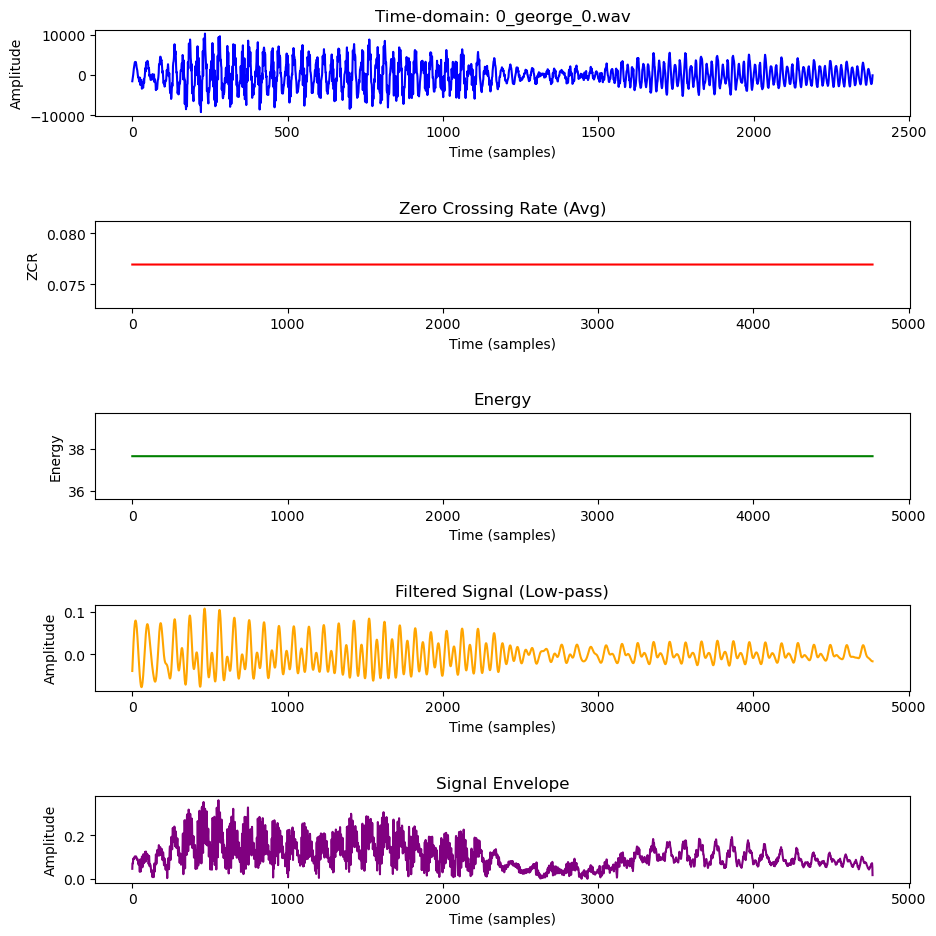

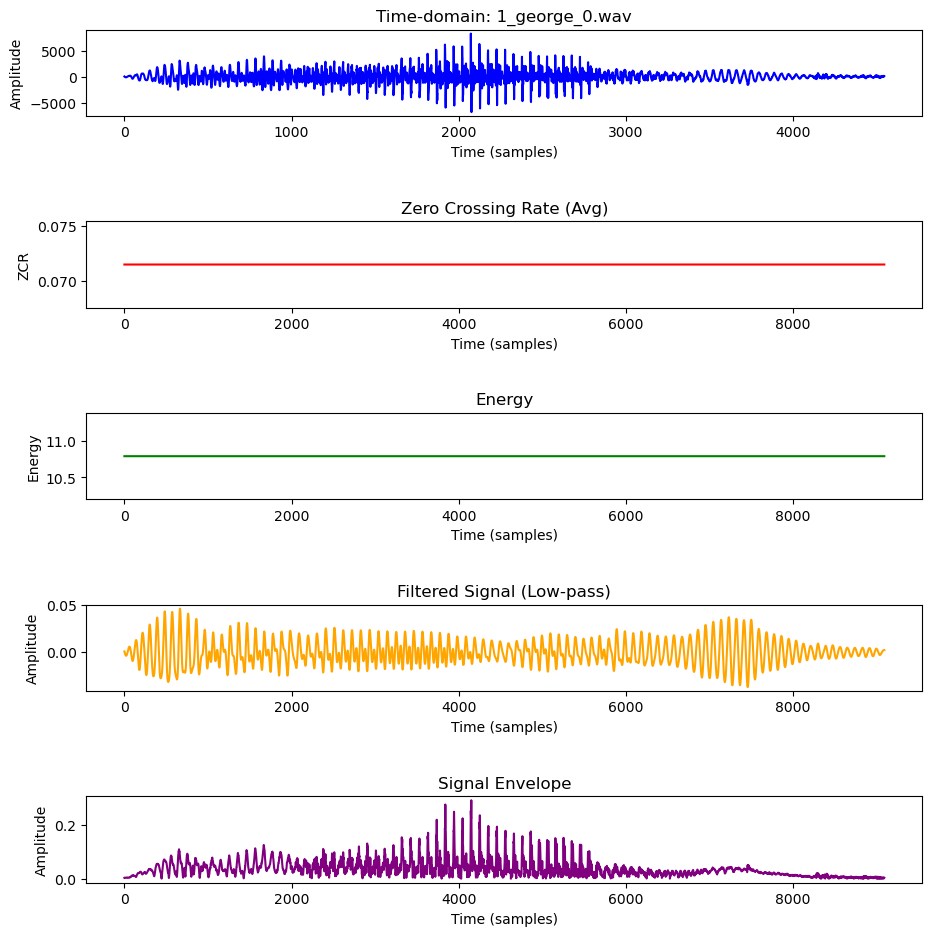

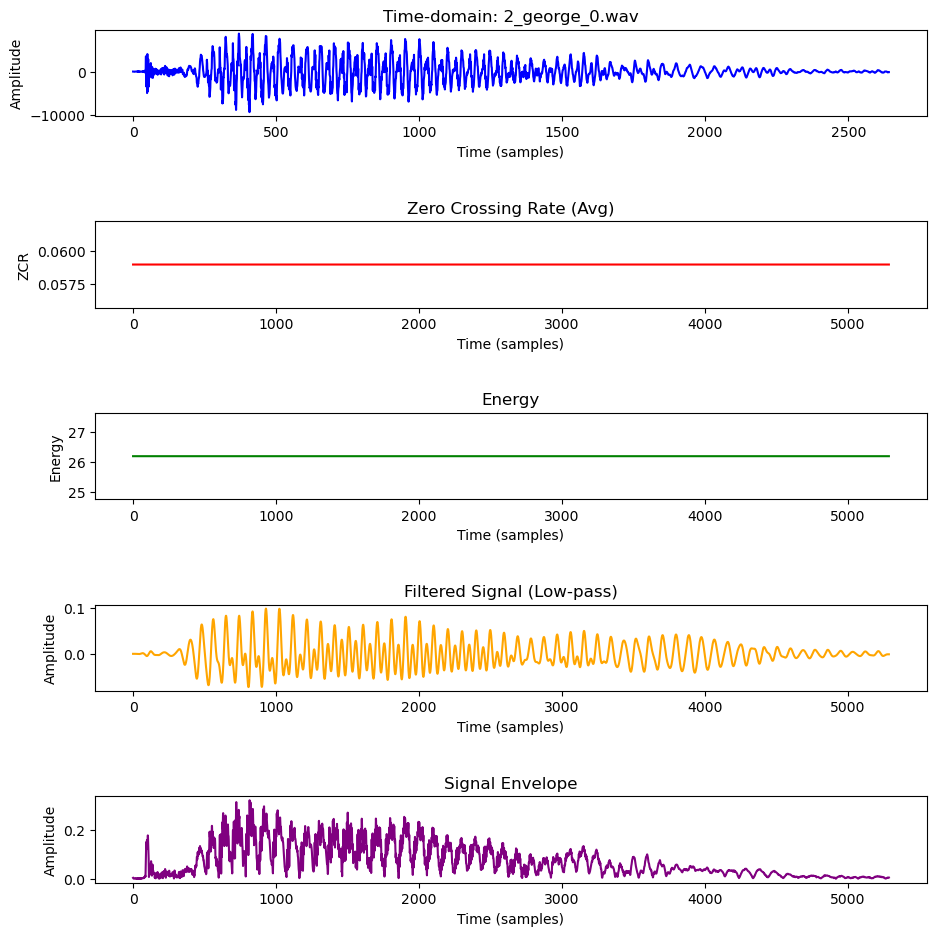

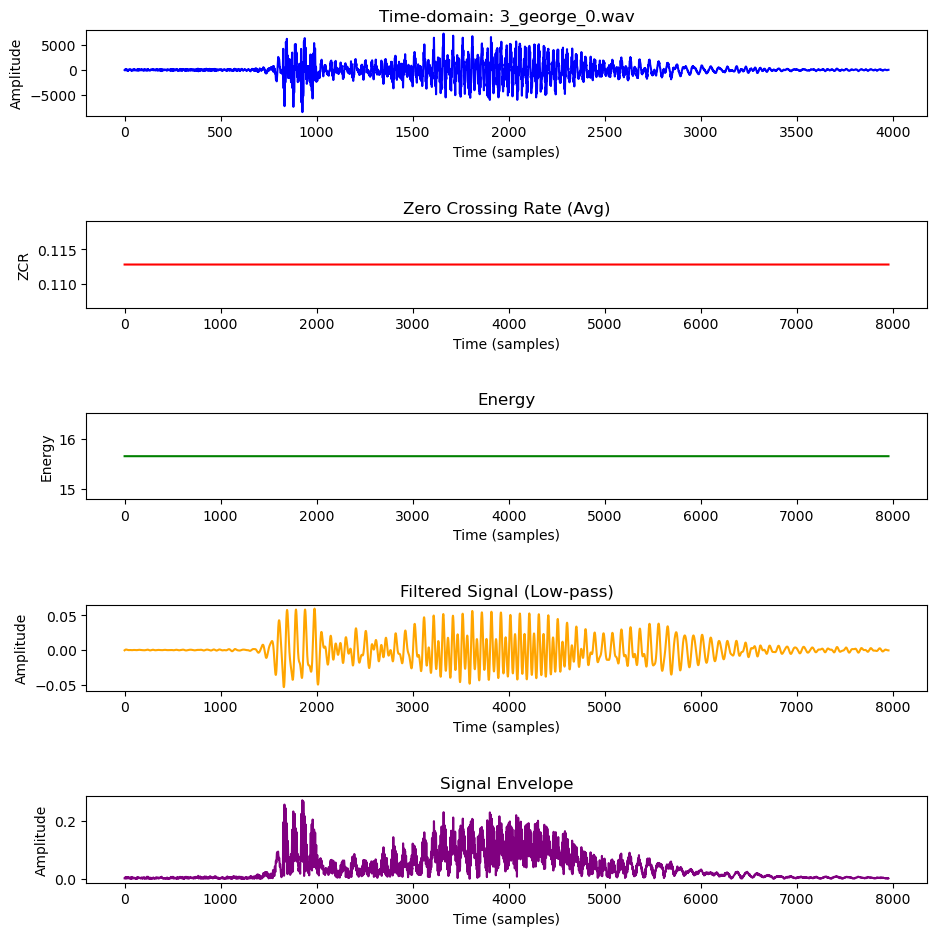

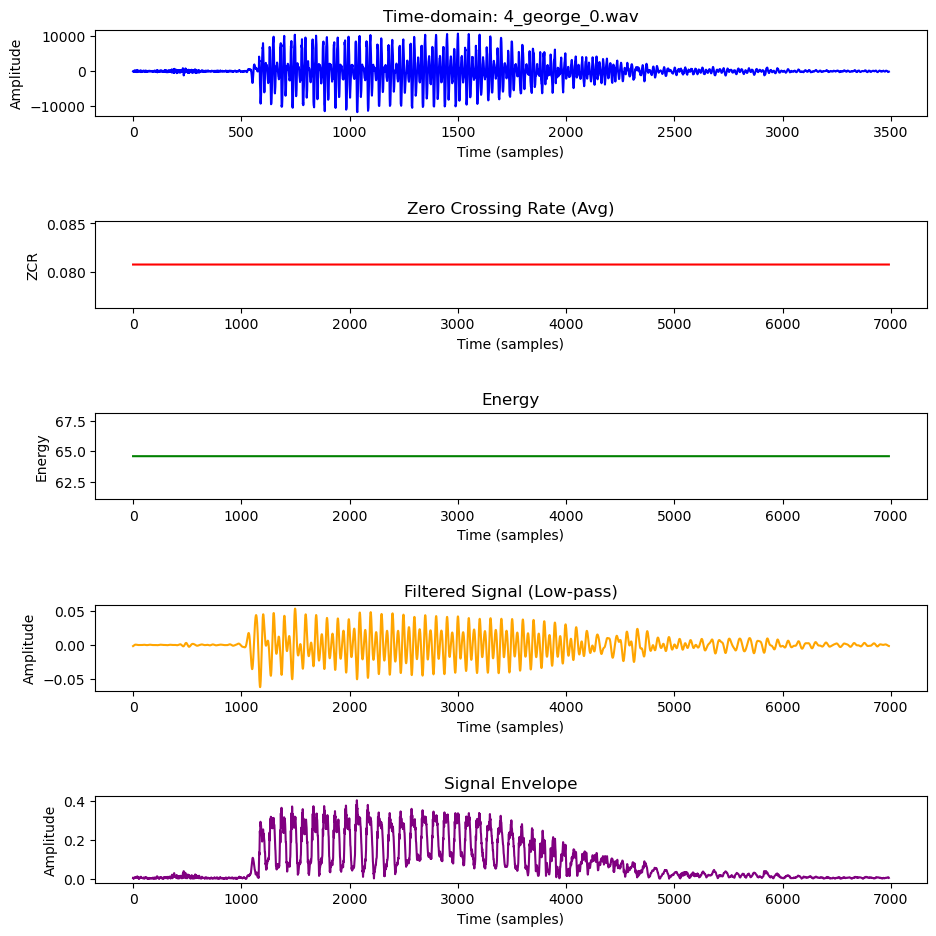

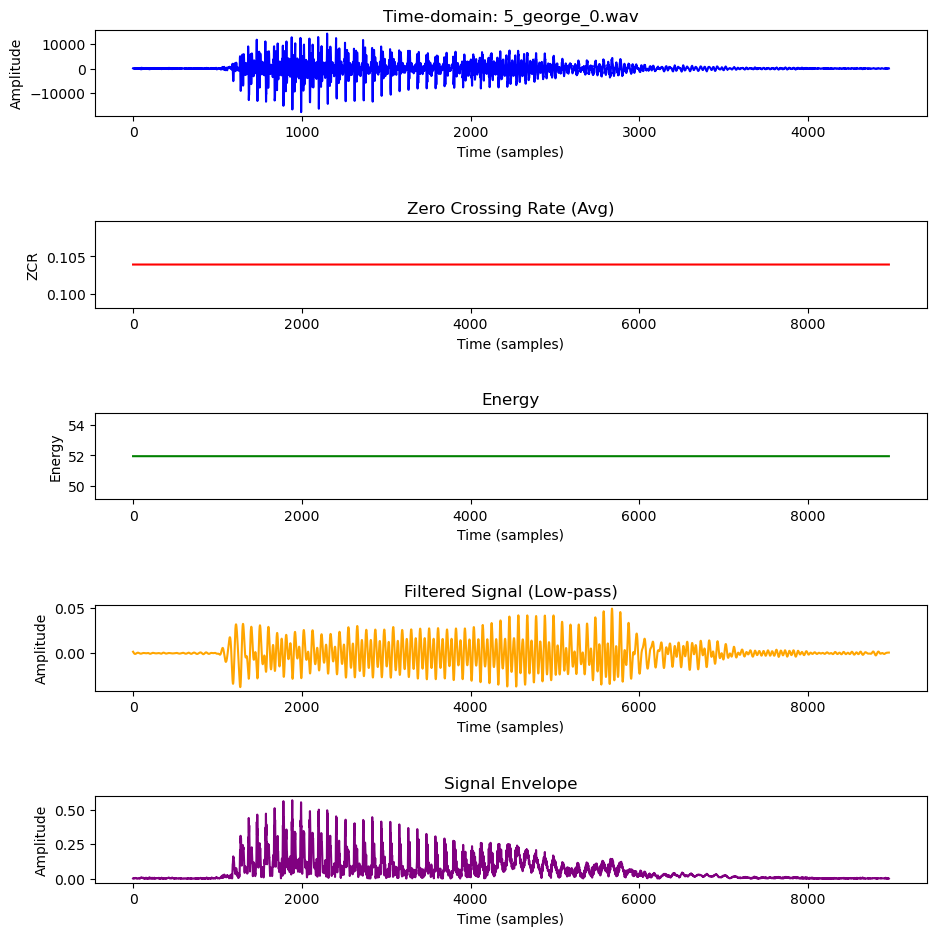

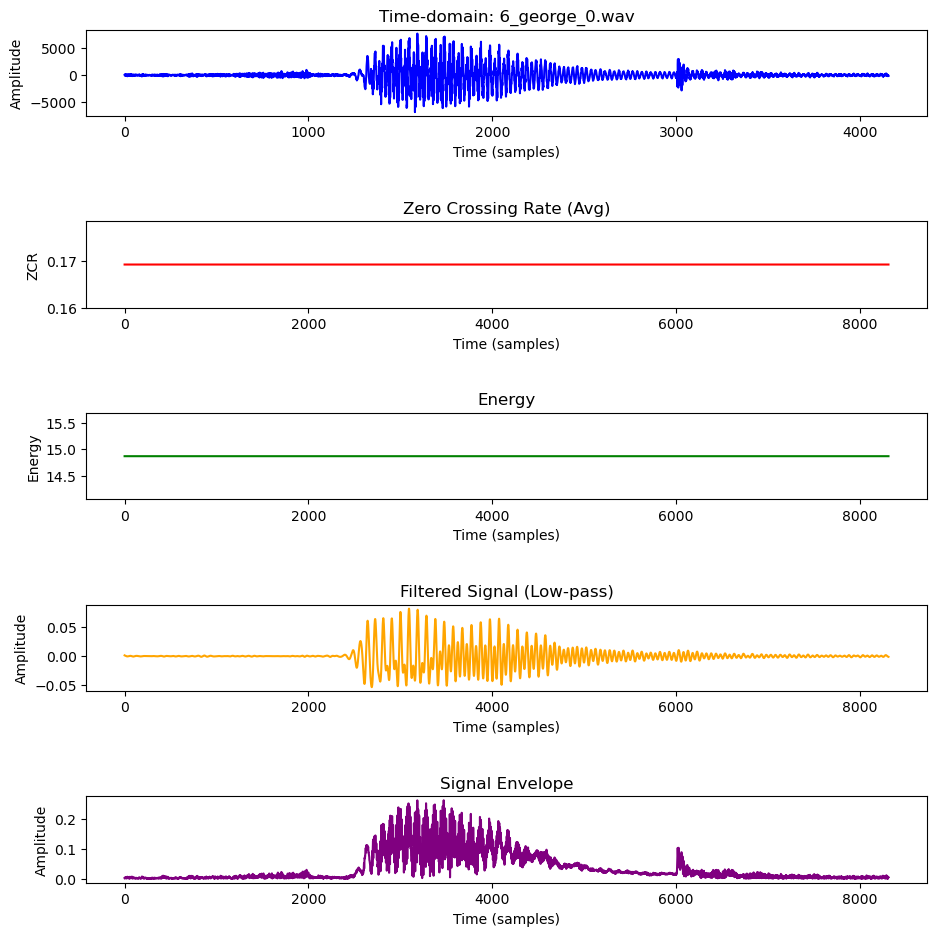

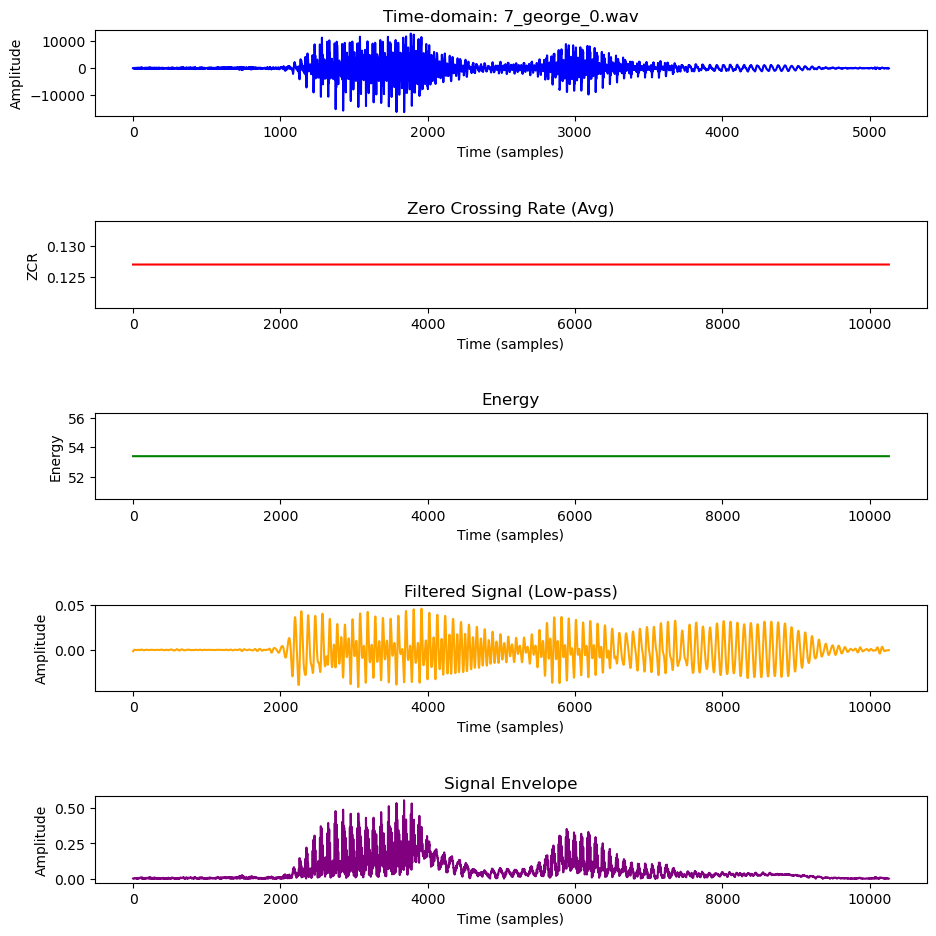

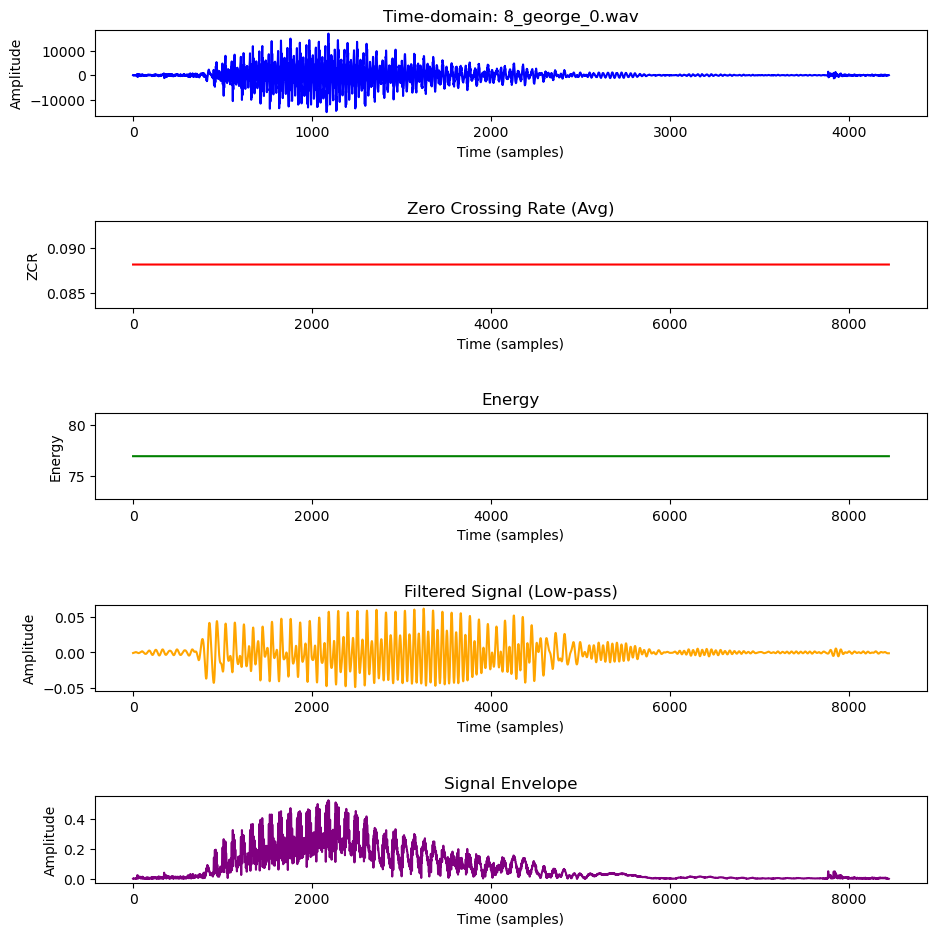

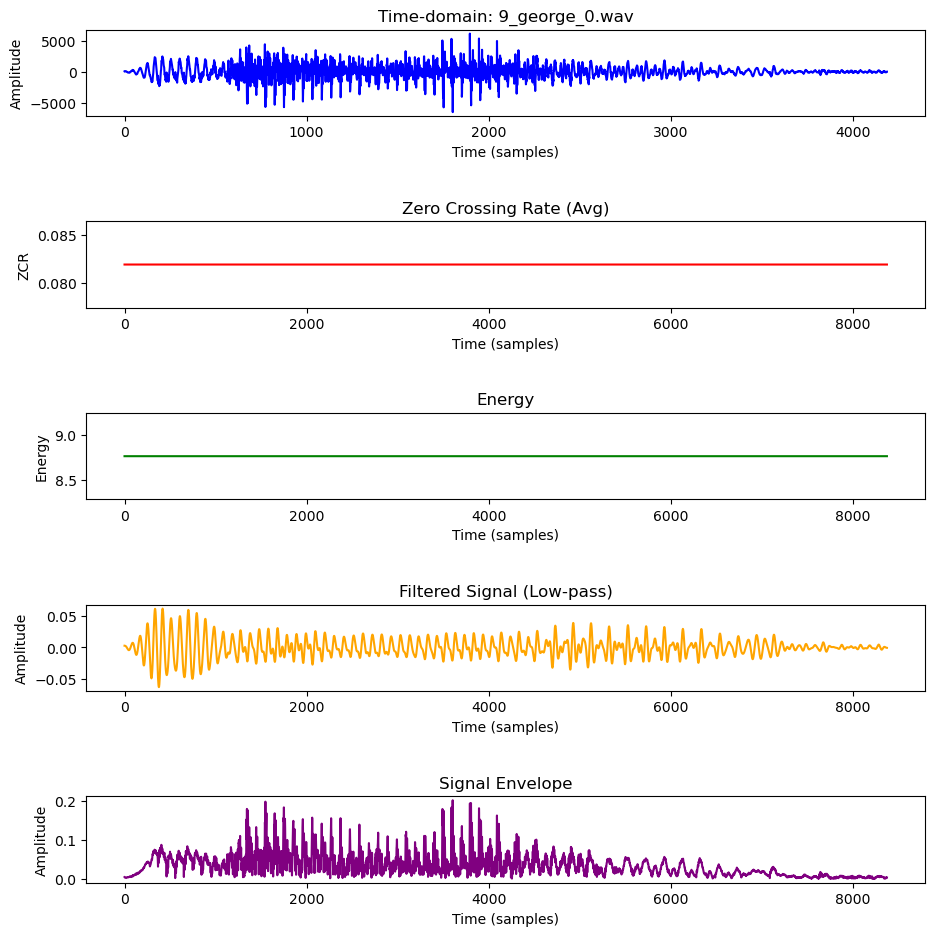

In [3]:
import os
import wave
import numpy as np
import librosa
import scipy.signal as signal
import matplotlib.pyplot as plt

time_domain_features = []
labels = []
plotted_digits = set()

for filename in data_list:
    digit = int(filename.split('_')[0])
    file_path = os.path.join(dataset_path, filename)

    # === Always extract features and labels ===
    signal_wave = wave.open(file_path, 'r')
    sample_rate = 16000
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)
    audio, sr = librosa.load(file_path, sr=sample_rate)

    zcr = np.mean(librosa.feature.zero_crossing_rate(audio))
    energy = np.sum(np.square(audio))

    time_domain_features.append([zcr, energy])
    labels.append(digit)

    # === Only plot first occurrence of each digit ===
    if digit not in plotted_digits:
        plotted_digits.add(digit)

        nyquist = 0.5 * sr
        low_cutoff = 300
        b, a = signal.butter(4, low_cutoff / nyquist, btype='low')
        filtered_signal = signal.filtfilt(b, a, audio)
        envelope = np.abs(signal.hilbert(audio))

        plt.figure(figsize=(10, 10))

        plot_a = plt.subplot(511)
        plot_a.set_title(f'Time-domain: {filename}')
        plot_a.plot(sig, color='blue')
        plot_a.set_xlabel('Time (samples)')
        plot_a.set_ylabel('Amplitude')

        plot_b = plt.subplot(512)
        plot_b.plot(np.ones_like(audio) * zcr, color='red')
        plot_b.set_title('Zero Crossing Rate (Avg)')
        plot_b.set_xlabel('Time (samples)')
        plot_b.set_ylabel('ZCR')

        plot_c = plt.subplot(513)
        plot_c.plot(np.ones_like(audio) * energy, color='green')
        plot_c.set_title('Energy')
        plot_c.set_xlabel('Time (samples)')
        plot_c.set_ylabel('Energy')

        plot_d = plt.subplot(514)
        plot_d.plot(filtered_signal, color='orange')
        plot_d.set_title('Filtered Signal (Low-pass)')
        plot_d.set_xlabel('Time (samples)')
        plot_d.set_ylabel('Amplitude')

        plot_e = plt.subplot(515)
        plot_e.plot(envelope, color='purple')
        plot_e.set_title('Signal Envelope')
        plot_e.set_xlabel('Time (samples)')
        plot_e.set_ylabel('Amplitude')

        plt.tight_layout(pad=3.0)
        plt.show()

    # === No break! Let the loop keep going for all 3000 files ===


# 2. Frequency domain Analysis

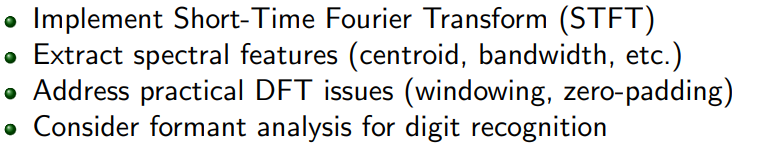

In [5]:
def extract_frequency_features(file_path, sample_rate=16000):
    audio, sr = librosa.load(file_path, sr=sample_rate)
    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))

    # Windowing
    audio_windowed = audio * np.hamming(len(audio))

    # STFT
    stft_result = librosa.stft(audio_windowed, n_fft=1024, hop_length=512)
    stft_magnitude = np.abs(stft_result)
    stft_mean = np.mean(stft_magnitude)
    stft_std = np.std(stft_magnitude)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    # Spectrogram
    spectrogram = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

    # Spectral features
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    flatness = librosa.feature.spectral_flatness(y=audio)[0]

    def extract_formants(signal, sr, lpc_order=12):
        try:
            A = librosa.lpc(signal, lpc_order)
            roots = np.roots(A)
            roots = [r for r in roots if np.imag(r) >= 0.01]
            if len(roots) == 0:
                return [0, 0, 0]
            angz = np.arctan2(np.imag(roots), np.real(roots))
            formants = sorted(angz * (sr / (2 * np.pi)))
            return formants[:3] if len(formants) >= 3 else [0, 0, 0]
        except Exception:
            return [0, 0, 0]

    formants = extract_formants(audio, sr)

    features = np.hstack([
        np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
        np.mean(spectrogram), np.std(spectrogram),
        np.mean(centroid), np.std(centroid),
        np.mean(rolloff), np.std(rolloff),
        np.mean(bandwidth), np.std(bandwidth),
        np.mean(flatness), np.std(flatness),
        stft_mean, stft_std,
        formants
    ])

    return features


In [7]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# === Dataset Path and File List ===
dataset_path = './free-spoken-digit-dataset-master/recordings/'
data_list = sorted([f for f in os.listdir(dataset_path) if f.endswith('.wav')])


# === Extract Features from Dataset ===
frequency_features = []
labels = []

for filename in data_list:
    file_path = os.path.join(dataset_path, filename)
    features = extract_frequency_features(file_path)
    frequency_features.append(features)
    labels.append(int(filename.split('_')[0]))  # assumes label is first part of filename


# 3. Wavelet Analysis

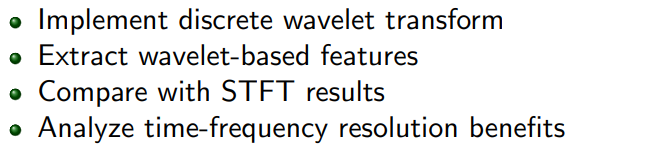

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import ipywidgets as widgets
from matplotlib.colors import LogNorm, Normalize
from IPython.display import display
from scipy import signal, interpolate
import matplotlib.ticker as ticker
import matplotlib.patches as patches

In [6]:
import random
import scipy.io.wavfile as wav
import os

def load_random_digit_zero_audio(dataset_path):
    """
    Load a random audio file of digit '0' from the dataset.

    Returns:
    --------
    time_vector : ndarray
        Time axis for the audio signal

    audio_signal : ndarray
        The loaded and normalized audio signal
    """
    # Step 1: Get all audio files corresponding to digit '0'
    digit_zero_filenames = [filename for filename in os.listdir(dataset_path) if filename.startswith("3_jackson_15")]
    
    # Step 2: Randomly choose one file from the list
    selected_audio_filename = random.choice(digit_zero_filenames)
    
    print(f"Selected file: {selected_audio_filename}")
    
    # Step 3: Load the selected WAV audio file
    sample_rate, audio_signal = wav.read(os.path.join(dataset_path, selected_audio_filename))
    
    # Step 4: Convert audio data to float type and normalize
    audio_signal = audio_signal.astype(float)
    audio_signal = audio_signal / np.max(np.abs(audio_signal))  # Normalize to [-1, 1]
    
    # Step 5: Create a time vector for plotting and analysis
    time_vector = np.linspace(0, len(audio_signal) / sample_rate, len(audio_signal))
    
    return time_vector, audio_signal


In [7]:
def compute_and_plot_dwt(signal_data, t, wavelet='db4', level=4, display_mode='coefficients', threshold_pct=0):
    """
    Compute and plot the Discrete Wavelet Transform
    """
    # Ensure level is not greater than what's possible with the signal length
    max_level = pywt.dwt_max_level(len(signal_data), pywt.Wavelet(wavelet).dec_len)
    level = min(level, max_level)

    # Compute DWT while keeping approximation coefficients at each level
    approx_coeffs = []
    detail_coeffs = []

    # Start with original signal
    a = signal_data

    # Perform decomposition level by level to capture all approximation coefficients
    for i in range(level):
        a, d = pywt.dwt(a, wavelet)
        approx_coeffs.append(a)
        detail_coeffs.append(d)

    # Reverse the lists to match the usual ordering (from higher to lower level)
    approx_coeffs.reverse()
    detail_coeffs.reverse()

    # Get the final approximation and all details
    approx = approx_coeffs[0]
    details = detail_coeffs

    # Compute regular wavedec for thresholding if needed
    if threshold_pct > 0:
        coeffs = pywt.wavedec(signal_data, wavelet, level=level)

        # Flatten coefficients
        coeff_array, coeff_slices = pywt.coeffs_to_array(coeffs)

        # Sort coefficients by absolute value
        sorted_indices = np.argsort(np.abs(coeff_array))

        # Calculate number of coefficients to zero out
        num_to_zero = int((threshold_pct / 100) * len(coeff_array))

        # Zero out smallest coefficients
        coeff_array[sorted_indices[:num_to_zero]] = 0

        # Convert back to nested list format
        coeffs = pywt.array_to_coeffs(coeff_array, coeff_slices, output_format='wavedec')
        approx = coeffs[0]
        details = coeffs[1:]

    # Calculate sampling frequency
    fs = 1 / (t[1] - t[0])
    nyquist = fs / 2

    # Different display modes
    if display_mode == 'coefficients':
        # Plot original signal, approximation coefficients at each level, and detail coefficients
        # Number of plots: original + (all approximations) + (all details)
        n_plots = 1 + level + level

        fig, axs = plt.subplots(n_plots, 1, figsize=(14, 2.5 * n_plots), sharex=False)

        # Plot original signal
        axs[0].plot(t, signal_data)
        axs[0].set_title('Original Signal')
        axs[0].set_ylabel('Amplitude')

        # Plot approximation coefficients at each level
        for i in range(level):
            # Get the approximation coefficient at this level
            a_coeff = approx_coeffs[i]

            # Create time vector for this level's coefficients
            x_a = np.linspace(0, t[-1], len(a_coeff))

            # Plot approximation coefficient
            axs[i+1].plot(x_a, a_coeff, 'r')
            axs[i+1].set_title(f'Approximation Coefficients (Level {level-i})')
            axs[i+1].set_ylabel('Amplitude')

            # Add frequency band info
            freq_upper = nyquist/(2**(level-i))
            freq_lower = 0
            axs[i+1].text(0.02, 0.02, f"Frequency band: 0-{freq_upper:.1f} Hz",
                         transform=axs[i+1].transAxes, fontsize=12,
                         bbox=dict(facecolor='white', alpha=0.7))

        # Plot detail coefficients at each level
        for i in range(level):
            # Get the detail coefficient at this level
            d_coeff = detail_coeffs[i]

            # Create time vector for this level's coefficients
            x_d = np.linspace(0, t[-1], len(d_coeff))

            # Plot detail coefficient
            axs[i+level+1].plot(x_d, d_coeff, 'b')
            axs[i+level+1].set_title(f'Detail Coefficients (Level {level-i})')
            axs[i+level+1].set_ylabel('Amplitude')

            # Add frequency band info
            freq_upper = nyquist/(2**(level-i-1))
            freq_lower = nyquist/(2**(level-i))
            axs[i+level+1].text(0.02, 0.02, f"Frequency band: {freq_lower:.1f}-{freq_upper:.1f} Hz",
                              transform=axs[i+level+1].transAxes, fontsize=12,
                              bbox=dict(facecolor='white', alpha=0.7))

        axs[-1].set_xlabel('Time (s)')
        plt.tight_layout()
        plt.show()

    # Time-frequency visualization code
    elif display_mode == 'time-frequency':
        # Create a heatmap-style time-frequency visualization
        fig, axes = plt.subplots(1, 1, figsize=(12, 4))

        # Plot original signal
        axes.plot(t, signal_data)
        axes.set_title('Original Signal')
        axes.set_xlabel('Time (s)')
        axes.set_ylabel('Amplitude')

        # Calculate frequency bands for each level
        freq_bands = []
        level_names = []

        # Add detail levels from highest to lowest frequency
        for i in range(level):
            freq_upper = nyquist/(2**(level-i-1))
            freq_lower = nyquist/(2**(level-i))
            freq_bands.append((freq_lower, freq_upper))
            level_names.append(f'D{level-i}')

        freq_bands.reverse()
        level_names.reverse()

        # Add approximation level (lowest frequency)
        freq_upper = nyquist/(2**level)
        freq_lower = 0
        freq_bands.append((freq_lower, freq_upper))
        level_names.append(f'A{level}')

        # Create arrays to store frequency band boundaries for y-axis
        y_positions = []
        for low, high in freq_bands:
            y_positions.append(low)
        y_positions.append(freq_bands[-1][1])  # Add the upper boundary of the last band

        # Create a matrix for the coefficients
        n_levels = len(freq_bands)
        n_time = len(t)

        # Initialize matrix with NaN (for better visualization)
        coeff_matrix = np.zeros((n_levels, n_time))

        # Fill matrix with detail coefficients (highest frequency to lowest)
        for i in range(level):
            # Get the detail coefficients
            d_coeffs = detail_coeffs[i]
            # Create a time array for these coefficients
            t_coeff = np.linspace(0, t[-1], len(d_coeffs))
            # Interpolate to match the time resolution of original signal
            if len(d_coeffs) > 1:
                interp_func = interpolate.interp1d(
                    t_coeff, np.abs(d_coeffs),
                    kind='linear',
                    bounds_error=False,
                    fill_value=0
                )
                # Fill matrix row
                coeff_matrix[n_levels-i-2, :] = interp_func(t)
            elif len(d_coeffs) == 1:  # Single coefficient case
                coeff_matrix[n_levels-i-2, :] = np.abs(d_coeffs[0])

        # Fill the approximation coefficients (lowest frequency)
        a_coeffs = approx_coeffs[0]
        t_a = np.linspace(0, t[-1], len(a_coeffs))
        if len(a_coeffs) > 1:
            interp_func = interpolate.interp1d(
                t_a, np.abs(a_coeffs),
                kind='linear',
                bounds_error=False,
                fill_value=0
            )
            coeff_matrix[-1, :] = interp_func(t)
        elif len(a_coeffs) == 1:
            coeff_matrix[-1, :] = np.abs(a_coeffs[0])

        # Normalize coeffecients for better visualization
        for i in range(n_levels):
            coeff_matrix[i, :] = coeff_matrix[i, :] / np.max(coeff_matrix[i, :])

        print(coeff_matrix.shape)

        plt.tight_layout()
        plt.show()

        n_levels, n_time = coeff_matrix.shape
        extent = [t[0], t[-1], 0, n_levels]

        # Create y-tick positions at the center of each row
        ytick_positions = np.arange(n_levels) + 0.5
        # Create custom labels combining level name and frequency band
        ytick_labels = [f"{name}\n{low:.1f}-{high:.1f} Hz"
                        for name, (low, high) in zip(level_names, freq_bands)]

        ytick_labels.reverse()

        fig, ax = plt.subplots(figsize=(14, 6))
        im = ax.imshow(coeff_matrix, aspect='auto', cmap='jet', extent=extent)

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency Band / Scale')
        ax.set_yticks(ytick_positions)
        ax.set_yticklabels(ytick_labels)
        ax.set_title("DWT Time-Frequency Representation (Horizontal Bars)")

        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Normalized Coefficient Magnitude')

        plt.tight_layout()
        plt.show()

    elif display_mode == 'energy':
        # Energy distribution visualization
        plt.figure(figsize=(14, 10))

        # Calculate energy in detail coefficients and final approximation coefficient
        energies = []
        labels = []

        # Calculate sampling frequency for frequency band labels
        fs = 1 / (t[1] - t[0])
        nyquist = fs / 2

        # Detail energies with frequency bands
        for i in range(level):
            detail_energy = np.sum(detail_coeffs[i]**2)
            energies.append(detail_energy)

            # Calculate frequency band
            freq_upper = nyquist / (2**(level-i-1))
            freq_lower = nyquist / (2**(level-i))

            labels.append(f'D{level-i}\n{freq_lower:.1f}-{freq_upper:.1f} Hz')

        energies.reverse()
        labels.reverse()

        # Final approximation energy with frequency band
        approx_energy = np.sum(approx_coeffs[0]**2)
        energies.append(approx_energy)

        # Calculate frequency band
        freq_upper = nyquist / (2**level)
        freq_lower = 0

        labels.append(f'A{level}\n{freq_lower:.1f}-{freq_upper:.1f} Hz')


        # Total energy and percentages
        total_energy = sum(energies)
        energies_percent = [100 * e / total_energy for e in energies]

        # Create bar chart of energy distribution
        plt.subplot(2, 1, 1)
        # Use different colors for approximation and detail coefficients
        colors = ['blue' if 'D' in label else 'red' for label in labels]
        plt.bar(labels, energies_percent, color=colors)
        plt.title('Energy Distribution by Decomposition Level (%)')
        plt.ylabel('Energy (%)')
        plt.grid(True, alpha=0.3)

        # Create pie chart
        plt.subplot(2, 1, 2)
        plt.pie(energies, labels=labels, autopct='%1.1f%%', colors=colors)
        plt.title('Energy Distribution Pie Chart')

        plt.tight_layout()
        plt.show()

        # Print energy distribution by frequency band
        print("Energy distribution by frequency band:")
        print("-" * 60)
        print(f"{'Level':<10}{'Frequency Band':<20}{'Energy':<15}{'Energy (%)':<15}")
        print("-" * 60)

        # Detail levels
        for i in range(level):
            freq_upper = nyquist / (2**(level-i-1))
            freq_lower = nyquist / (2**(level-i))
            level_name = f'D{level-i}'
            energy = energies[i]
            energy_percent = energies_percent[i]
            print(f"{level_name:<10}{f'{freq_lower:.1f}-{freq_upper:.1f} Hz':<20}{energy:<15.2f}{energy_percent:.2f}%")

        # Final approximation level
        freq_upper = nyquist / (2**level)
        freq_lower = 0
        level_name = f'A{level}'
        energy = energies[-1]
        energy_percent = energies_percent[-1]
        print(f"{level_name:<10}{f'{freq_lower:.1f}-{freq_upper:.1f} Hz':<20}{energy:<15.2f}{energy_percent:.2f}%")

    # Create a list of (approximation, detail) coefficients for returning
    result_coeffs = list(zip(approx_coeffs, detail_coeffs))
    return result_coeffs



# Update the display mode widget
display_mode_widget = widgets.Dropdown(
    options=[
        ('Coefficient View', 'coefficients'),
        ('Time-Frequency Heatmap', 'time-frequency'),
        ('Energy Distribution', 'energy')
    ],
    value='coefficients',  # Set default to time-frequency view
    description='Display Mode:'
)

threshold_widget = widgets.FloatSlider(
    value=0,
    min=0,
    max=95,
    step=5,
    description='Threshold %:',
    tooltip='Percentage of smallest coefficients to set to zero'
)

# Add noise level widget for DWT
dwt_noise_level_widget = widgets.FloatSlider(
    value=0.05,
    min=0.0,
    max=0.5,
    step=0.01,
    description='Noise Level:',
    tooltip='Amount of noise added to the signals'
)

# Interactive widget for DWT with improved controls
dwt_wavelet_widget = widgets.Dropdown(
    options=['haar', 'db1', 'db2', 'db4', 'db8', 'sym2', 'sym4', 'sym8', 'coif1', 'coif3', 'bior1.3', 'bior2.2', 'bior3.5'],
    value='db4',
    description='Wavelet:'
)

# dwt_signal_choice_widget = widgets.Dropdown(
#     options=['sine', 'chirp', 'transient', 'mixture', 'all'],
#     value='sine',
#     description='Signal:'
# )

dwt_level_widget = widgets.IntSlider(
    value=3,
    min=1,
    max=5,
    step=1,
    description='Level:',
    tooltip='Decomposition level'
)

def update_dwt(wavelet,level, display_mode, threshold_pct, noise_level):
    
    
    time_vector, audio_signal = load_random_digit_zero_audio(dataset_path)

    signal_data = audio_signal
    t = time_vector

    if noise_level > 0:
        noise = np.random.normal(0, noise_level, size=signal_data.shape)
        signal_data = signal_data + noise
        signal_data = signal_data / np.max(np.abs(signal_data))  # Keep signal normalized

    return compute_and_plot_dwt(signal_data, t, wavelet, level, display_mode, threshold_pct)

# Interactive output with added controls
dwt_interactive_output = widgets.interactive_output(
    update_dwt,
    {'wavelet': dwt_wavelet_widget,
     'level': dwt_level_widget,
     'display_mode': display_mode_widget,
     'threshold_pct': threshold_widget,
     'noise_level': dwt_noise_level_widget}
)

# Display widgets with improved organization
dwt_controls = widgets.VBox([
    widgets.HBox([
        widgets.VBox([
            dwt_noise_level_widget
        ]),
        widgets.VBox([
            dwt_wavelet_widget,
            dwt_level_widget
        ]),
        widgets.VBox([
            display_mode_widget,
            threshold_widget
        ])
    ])
])

# Note: Make sure create_test_signals is defined as in previous examples
display(dwt_controls, dwt_interactive_output)

Output()

## Specific results

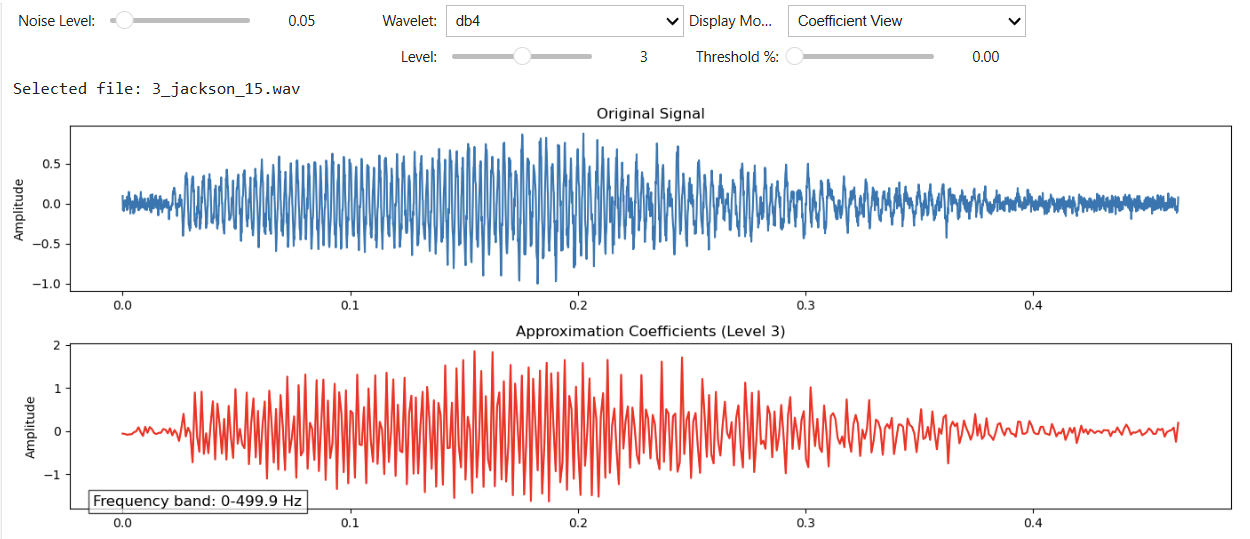
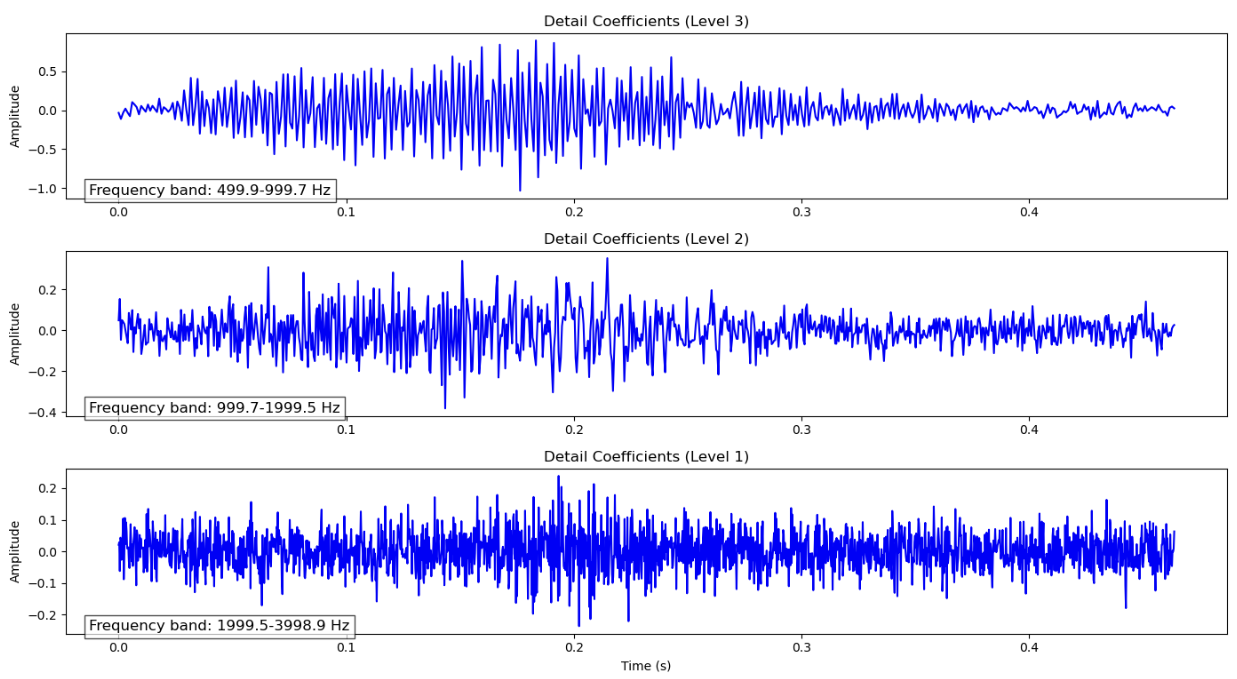
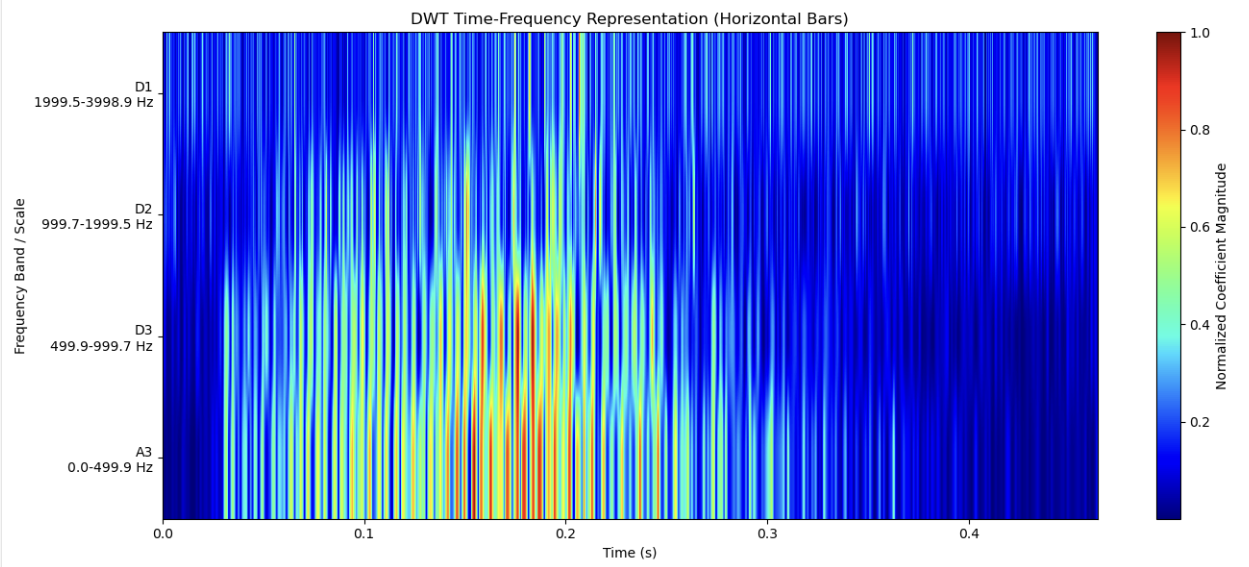
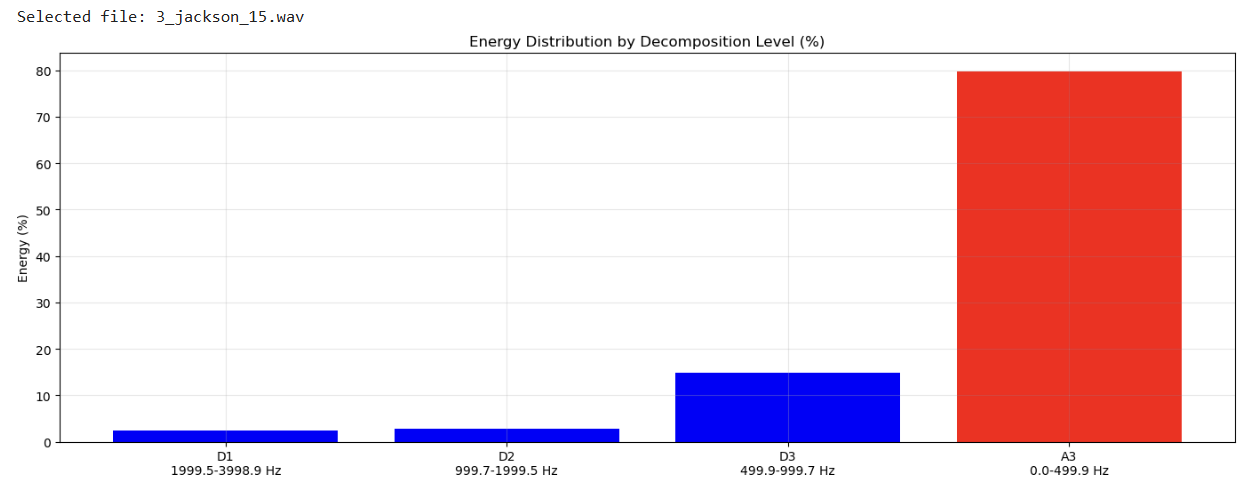
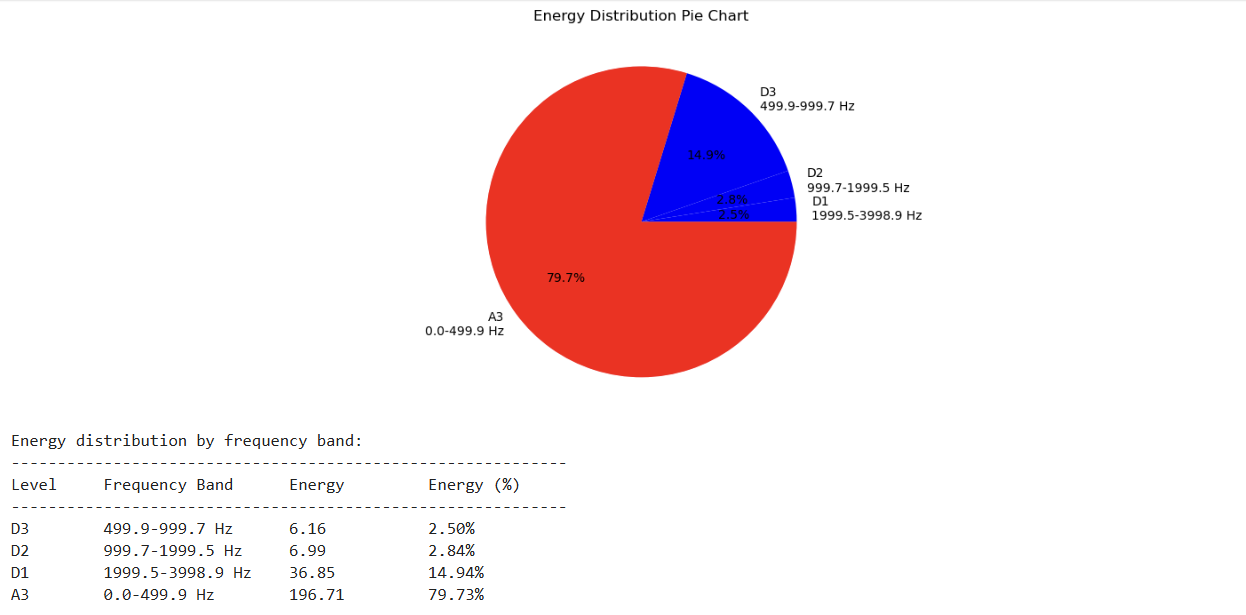

In [15]:
import os
import numpy as np
import pywt
import scipy.io.wavfile as wav
import pandas as pd

def extract_wavelet_features(signal_data, wavelet='db4', level=3):
    coeffs = pywt.wavedec(signal_data, wavelet, level=level)
    features = {}

    for i, c in enumerate(coeffs):
        level_name = f"A{level}" if i == 0 else f"D{level - i + 1}"
        energy = np.sum(c ** 2)
        probs = (c**2) / (energy + 1e-12)  # Safe divide
        entropy = -np.sum(probs * np.log2(probs + 1e-12))

        features[f'{level_name}_energy'] = energy
        features[f'{level_name}_entropy'] = entropy
        features[f'{level_name}_mean'] = np.mean(c)
        features[f'{level_name}_std'] = np.std(c)
        features[f'{level_name}_max'] = np.max(c)
        features[f'{level_name}_min'] = np.min(c)

        # Optional: zero-crossings in that level
        zero_crossings = np.sum(np.diff(np.sign(c)) != 0)
        features[f'{level_name}_zcr'] = zero_crossings

    return features

def load_and_preprocess_wav(filepath):
    sample_rate, signal = wav.read(filepath)
    signal = signal.astype(float)
    signal = signal / np.max(np.abs(signal))  # Normalize
    return signal

def batch_extract_features(dataset_path, wavelet='db4', level=4):
    all_features = []

    for filename in os.listdir(dataset_path):
        if filename.endswith(".wav") and filename[0].isdigit():
            filepath = os.path.join(dataset_path, filename)
            label = int(filename[0])  # Get digit from filename
            signal = load_and_preprocess_wav(filepath)
            features = extract_wavelet_features(signal, wavelet, level)
            features['label'] = label
            features['file'] = filename
            all_features.append(features)

    df = pd.DataFrame(all_features)
    return df


In [17]:
dataset_path = "./free-spoken-digit-dataset-master/recordings"
df = batch_extract_features(dataset_path, wavelet='db4', level=3)

print(df.head())
df.to_csv("wavelet_features_fsdd.csv", index=False)

    A3_energy  A3_entropy   A3_mean    A3_std    A3_max    A3_min  A3_zcr  \
0  134.119196    7.191153 -0.001463  0.664213  1.717208 -1.706761     220   
1  119.583089    7.554403 -0.000086  0.447556  1.731893 -1.391298     368   
2  121.293924    7.328612 -0.000360  0.402151  1.591067 -1.477376     462   
3  124.666077    7.211414  0.000337  0.518900  1.795965 -1.589056     303   
4  133.788144    7.468182  0.000399  0.511180  1.892017 -1.842853     304   

   D3_energy  D3_entropy   D3_mean  ...  D2_zcr  D1_energy  D1_entropy  \
0  24.417367    7.376750  0.002046  ...     207  22.153151    7.628281   
1  34.180144    7.423173 -0.000578  ...     572   5.943527    8.458164   
2  41.900866    7.173959  0.000049  ...     665  13.786318    7.974114   
3  44.728947    7.250928 -0.000543  ...     413  25.097816    7.783872   
4  47.329179    7.303814  0.001350  ...     428  26.901615    8.128517   

    D1_mean    D1_std    D1_max    D1_min  D1_zcr  label             file  
0 -0.000007  0.1

In [19]:
print(df.shape)


(3000, 30)


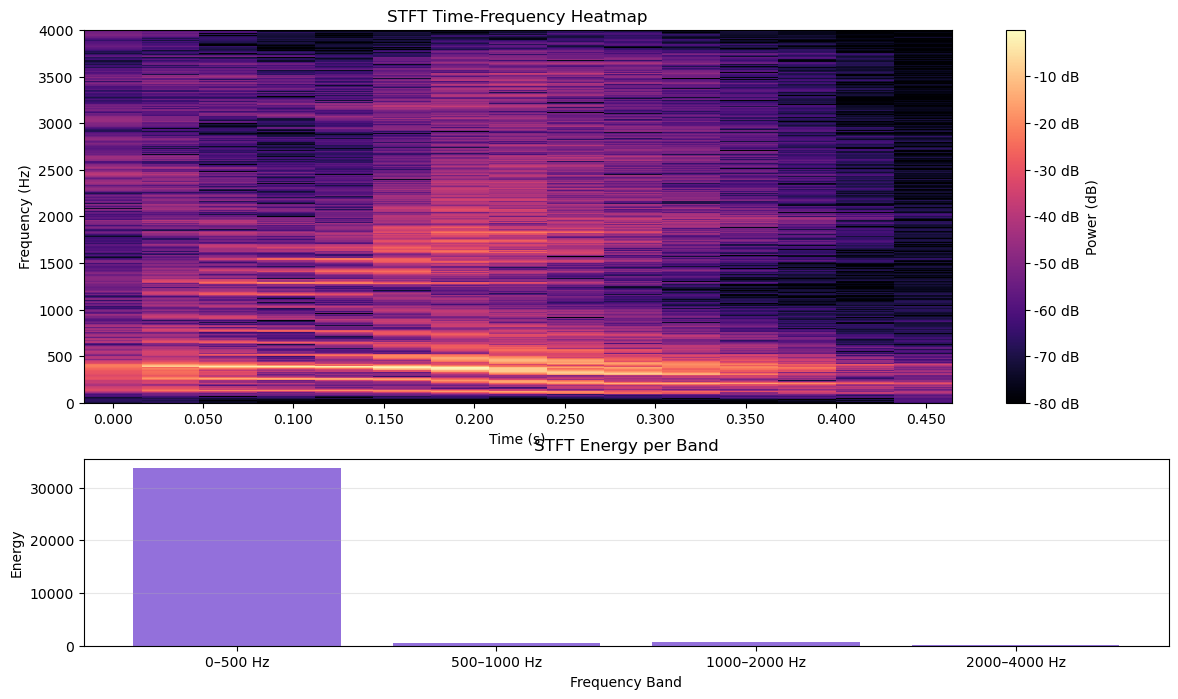

<Figure size 800x400 with 0 Axes>

In [21]:
## STFT


import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os

# File selection
dataset_path = "./free-spoken-digit-dataset-master/recordings"
filename = "3_jackson_15.wav"
filepath = os.path.join(dataset_path, filename)

# Load audio file
audio, sr = librosa.load(filepath, sr=None)
sr = 8000
# Duration and time vector
duration = len(audio) / sr
t = np.linspace(0, duration, len(audio))

#  STFT Parameters
n_fft = 1024
hop_length = 256
stft_result = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
stft_magnitude = np.abs(stft_result)

# Linear-scale energy per frequency bin (sum over time)
stft_band_energy = np.sum(stft_magnitude**2, axis=1)

stft_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

freqs = np.linspace(0, sr/2, len(stft_band_energy))  # Map bin index to Hz

# -------------------------------
#  Plot STFT Heatmap + Energy
# -------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [2, 1]})

#  Heatmap (Time-Frequency)
img = librosa.display.specshow(stft_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear', ax=ax1)
ax1.set_title("STFT Time-Frequency Heatmap")
ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
fig.colorbar(img, ax=ax1, format='%+2.0f dB', label="Power (dB)")



# Group STFT energy into 4 bands to match DWT
bands = {
    "0–500 Hz": (0, 500),
    "500–1000 Hz": (500, 1000),
    "1000–2000 Hz": (1000, 2000),
    "2000–4000 Hz": (2000, 4000)
}

band_energies = []
band_labels = []

for label, (f_low, f_high) in bands.items():
    idx_band = np.where((freqs >= f_low) & (freqs < f_high))[0]
    energy = np.sum(stft_band_energy[idx_band])
    band_energies.append(energy)
    band_labels.append(label)

#  Plot grouped STFT energy (similar to DWT bar chart)
plt.figure(figsize=(8, 4))
ax2.bar(band_labels, band_energies, color='mediumpurple')
ax2.set_title("STFT Energy per Band")
ax2.set_xlabel("Frequency Band")
ax2.set_ylabel("Energy")
ax2.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

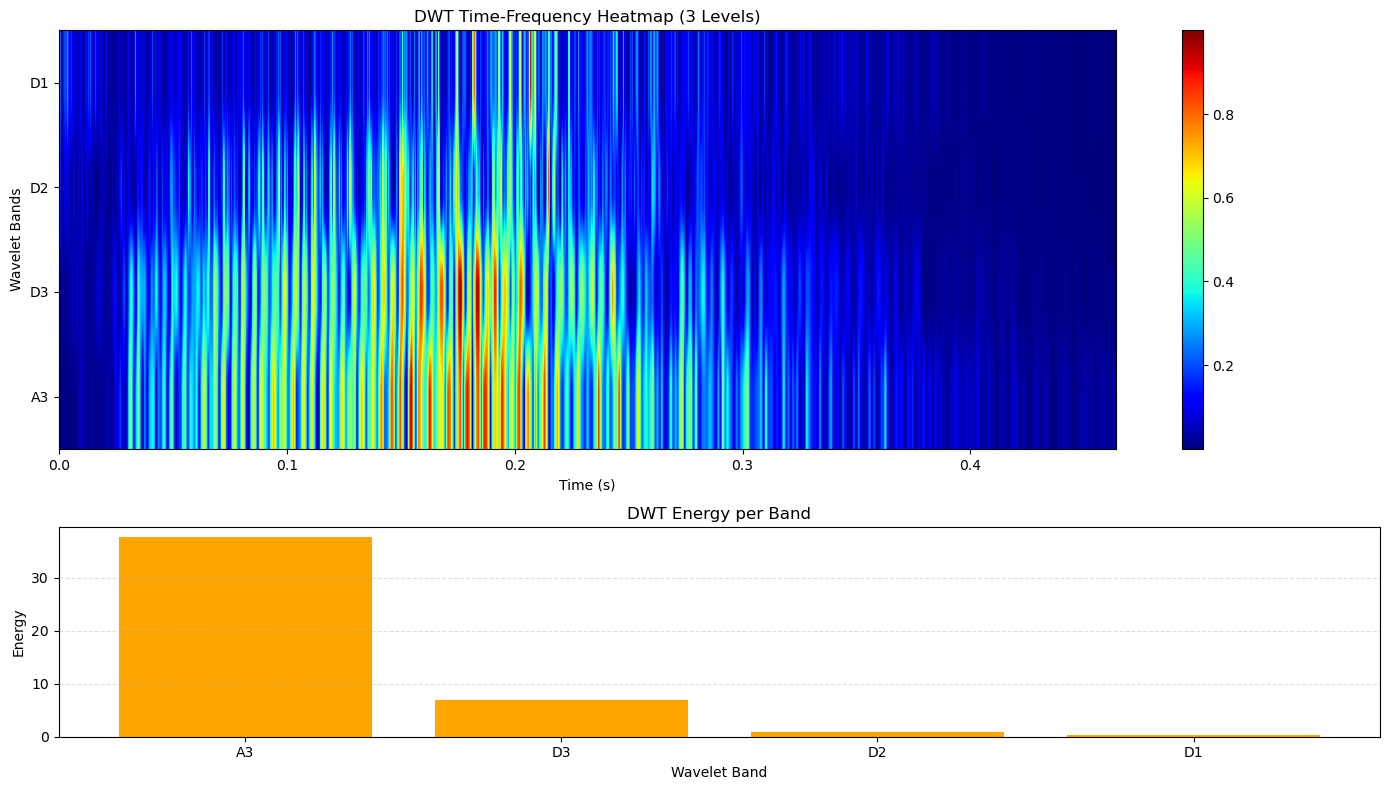

In [55]:
# DWT , for the purpose of comparison

import numpy as np
import matplotlib.pyplot as plt
import pywt
import librosa
import os

# -----------------------
#  Load Audio File
# -----------------------
dataset_path = "./free-spoken-digit-dataset-master/recordings"
filename = "3_jackson_15.wav"
filepath = os.path.join(dataset_path, filename)

# Load audio
audio, sr = librosa.load(filepath, sr=None)
duration = len(audio) / sr
t = np.linspace(0, duration, len(audio))

# -----------------------
#  Apply DWT
# -----------------------
wavelet = 'db4'
level = 3
coeffs = pywt.wavedec(audio, wavelet=wavelet, level=level)

# Separate approx and details
approx = coeffs[0]       # A3
details = coeffs[1:]     # [D3, D2, D1]

# Labels: A3 at bottom, D3→D1 upward
dwt_band_labels = [f"A{level}"] + [f"D{i}" for i in range(level, 0, -1)]

# -----------------------
#  Energy per Band
# -----------------------
dwt_energies = [np.sum(approx**2)] + [np.sum(d**2) for d in details]

# -----------------------
#  Build DWT Time-Frequency Matrix
# -----------------------
n_levels = level + 1
coeff_matrix = np.zeros((n_levels, len(audio)))

# Order: A3 (bottom), D3, D2, D1 (top)
coeff_order = [approx] + details

for i, coeff in enumerate(coeff_order):
    coeff_time = np.linspace(0, duration, len(coeff))
    interp = np.interp(t, coeff_time, np.abs(coeff))
    coeff_matrix[i, :] = interp / (np.max(interp) + 1e-8)

# -----------------------
#  Plot Heatmap + Energy
# -----------------------
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

#  DWT Heatmap
ax1 = fig.add_subplot(gs[0])
im = ax1.imshow(coeff_matrix, aspect='auto', origin='lower',
                extent=[0, duration, 0, n_levels], cmap='jet')
ax1.set_title("DWT Time-Frequency Heatmap (3 Levels)")
ax1.set_yticks(np.arange(n_levels) + 0.5)
ax1.set_yticklabels(dwt_band_labels)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Wavelet Bands")
plt.colorbar(im, ax=ax1)








# Energy Bar Chart
ax2 = fig.add_subplot(gs[1])
ax2.bar(dwt_band_labels, dwt_energies, color='orange')
ax2.set_title("DWT Energy per Band")
ax2.set_xlabel("Wavelet Band")
ax2.set_ylabel("Energy")
ax2.grid(True, axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


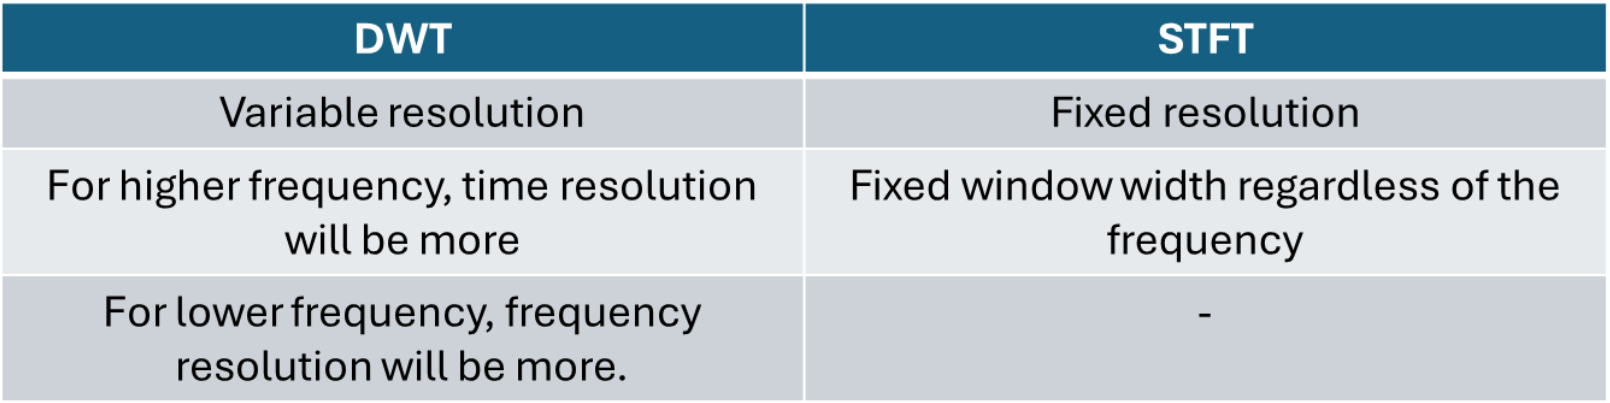

# 4. Classification System

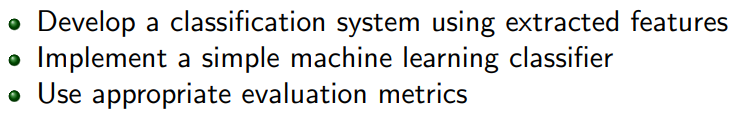

Epoch 1/10, Loss: 2.2186
Epoch 2/10, Loss: 2.1093
Epoch 3/10, Loss: 2.0855
Epoch 4/10, Loss: 2.0614
Epoch 5/10, Loss: 2.0496
Epoch 6/10, Loss: 2.0380
Epoch 7/10, Loss: 2.0213
Epoch 8/10, Loss: 2.0198
Epoch 9/10, Loss: 2.0201
Epoch 10/10, Loss: 2.0111
Test Accuracy: 28.00%
Classification Report:
              precision    recall  f1-score   support

           0     0.5000    0.1667    0.2500        60
           1     0.1914    0.5167    0.2793        60
           2     0.3333    0.0167    0.0317        60
           3     0.1739    0.0667    0.0964        60
           4     0.2955    0.4333    0.3514        60
           5     0.1972    0.4667    0.2772        60
           6     0.6721    0.6833    0.6777        60
           7     0.2000    0.0667    0.1000        60
           8     0.3111    0.2333    0.2667        60
           9     0.2500    0.1500    0.1875        60

    accuracy                         0.2800       600
   macro avg     0.3124    0.2800    0.2518       600


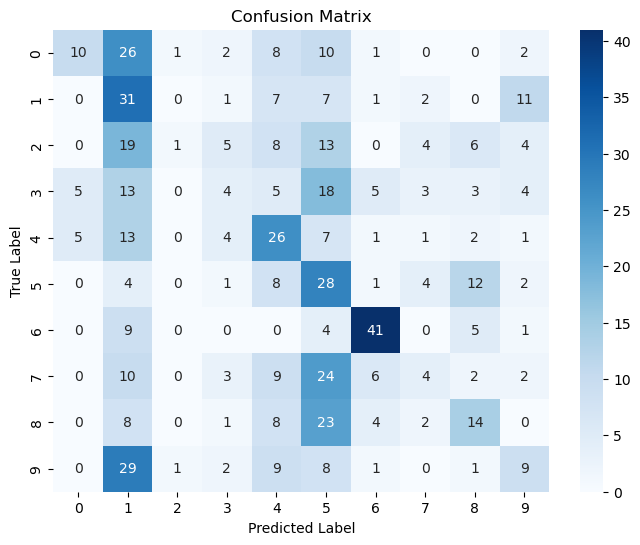

In [33]:
# === MLP CLASSIFIER FOR SPOKEN DIGITS USING TIME-DOMAIN FEATURES (PYTORCH VERSION) ===

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Convert to Arrays ===
X = np.array(time_domain_features)
y = np.array(labels)

# === Encode Labels ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# === Normalize Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Split Data ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# === Convert to PyTorch tensors ===
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# === Data Loaders ===
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# === Define MLP Model ===
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, output_dim=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(hidden2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.output(x)

# === Instantiate Model, Loss, Optimizer ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# === Train Model ===
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# === Evaluate Model ===
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# === Detailed Evaluation ===
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# === Optional: Save Model ===
# torch.save(model.state_dict(), "mlp_digit_classifier_time_domain.pth")


Epoch 1/10, Loss: 1.9268
Epoch 2/10, Loss: 1.0335
Epoch 3/10, Loss: 0.6865
Epoch 4/10, Loss: 0.5616
Epoch 5/10, Loss: 0.4755
Epoch 6/10, Loss: 0.4237
Epoch 7/10, Loss: 0.3926
Epoch 8/10, Loss: 0.3770
Epoch 9/10, Loss: 0.3598
Epoch 10/10, Loss: 0.3350
Test Accuracy: 95.33%
Classification Report:
              precision    recall  f1-score   support

           0     0.9667    0.9667    0.9667        60
           1     0.9344    0.9500    0.9421        60
           2     0.9672    0.9833    0.9752        60
           3     0.8594    0.9167    0.8871        60
           4     1.0000    0.9833    0.9916        60
           5     0.9672    0.9833    0.9752        60
           6     0.9423    0.8167    0.8750        60
           7     0.9836    1.0000    0.9917        60
           8     0.9516    0.9833    0.9672        60
           9     0.9661    0.9500    0.9580        60

    accuracy                         0.9533       600
   macro avg     0.9539    0.9533    0.9530       600


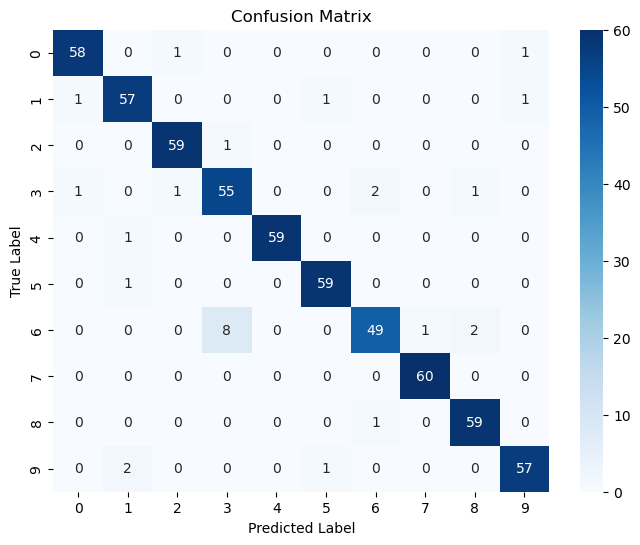

In [35]:
# === MLP CLASSIFIER FOR SPOKEN DIGITS USING FREQUENCY-DOMAIN FEATURES (PYTORCH VERSION) ===


# === Convert to Arrays ===
X = np.array(frequency_features)
y = np.array(labels)

# === Encode Labels ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# === Normalize Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Split Data ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# === Convert to PyTorch tensors ===
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# === Data Loaders ===
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# === Define MLP Model ===
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, output_dim=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(hidden2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.output(x)

# === Instantiate Model, Loss, Optimizer ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# === Train Model ===
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# === Evaluate Model ===
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# === Detailed Evaluation ===
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# === Optional: Save Model ===
# torch.save(model.state_dict(), "mlp_digit_classifier_frequency_domain.pth")


Epoch 1/10, Loss: 1.7645
Epoch 2/10, Loss: 1.1487
Epoch 3/10, Loss: 0.9722
Epoch 4/10, Loss: 0.8607
Epoch 5/10, Loss: 0.7811
Epoch 6/10, Loss: 0.7543
Epoch 7/10, Loss: 0.6678
Epoch 8/10, Loss: 0.6364
Epoch 9/10, Loss: 0.6107
Epoch 10/10, Loss: 0.5920
Test Accuracy: 85.67%
Classification Report:
              precision    recall  f1-score   support

           0     0.8704    0.7833    0.8246        60
           1     0.9216    0.7833    0.8468        60
           2     0.8214    0.7667    0.7931        60
           3     0.6812    0.7833    0.7287        60
           4     0.8657    0.9667    0.9134        60
           5     0.8358    0.9333    0.8819        60
           6     0.9298    0.8833    0.9060        60
           7     0.9804    0.8333    0.9009        60
           8     0.8594    0.9167    0.8871        60
           9     0.8594    0.9167    0.8871        60

    accuracy                         0.8567       600
   macro avg     0.8625    0.8567    0.8570       600


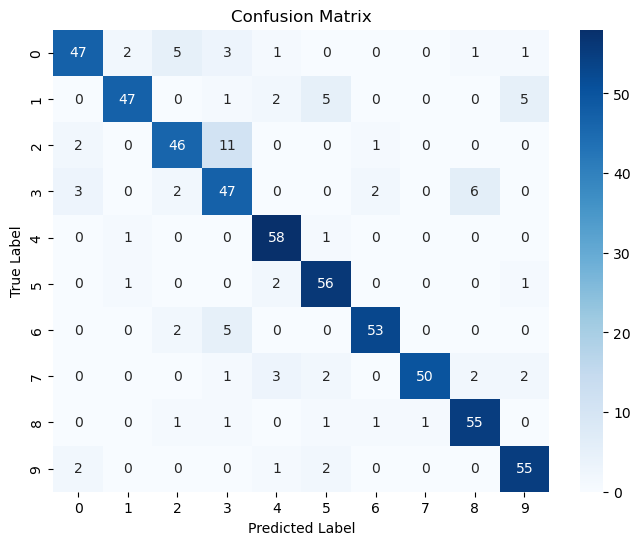

In [37]:
# Classification system - MLP

# === MLP CLASSIFIER FOR SPOKEN DIGITS USING WAVELET FEATURES (PYTORCH VERSION) ===

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# === Load dataset from CSV ===
#data = pd.read_csv("/mnt/data/wavelet_features_fsdd.csv")

# Assume last two columns are: 'label' and 'filename'
X = df.iloc[:, :-2].values  # All feature columns
y = df.iloc[:, -2].values   # Label column

# === Encode labels ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# === Normalize Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Split Data ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# === Convert to PyTorch tensors ===
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# === Data Loaders ===
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# === Define MLP Model ===
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64, output_dim=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(hidden2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.output(x)

# === Instantiate Model, Loss, Optimizer ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# === Train Model ===
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# === Evaluate Model ===
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# === Detailed Evaluation ===
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# === Optional: Save Model ===
# torch.save(model.state_dict(), "mlp_digit_classifier_wavelet_domain.pth")


## Check the GitHub repository: https://github.com/Tarekh03/EE413-spoken-digit-classifier 

Thank you!

Team 5:
- Tarek Alhouri | 202045120
- Hassan Hizeh | 202045800
- Faisal Mazeed | 202030320
- Zinalabidin Aman | 202011780